In [3]:
%matplotlib inline

# All TEMCA optical image processing

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import boto3
import skimage.io as io
import skimage
from skimage import data
from skimage import feature
from skimage import color
from skimage import filters
from skimage import transform 
from skimage import draw
from skimage import measure
from skimage import morphology
import skdemo
from scipy import ndimage as ndi
from toolbox.TAO.tao import TAO
from toolbox.TAO.taoDB import TAOdb

In [ ]:
taoDB = TAOdb()

In [49]:
ai = {
    'imfull': None, # the complete image, including barcode
    'imbarcode': None, # just the barcode
    'imrgb': None, # cropped image
    'imgray': None, # grayscale version of cropped
    'imhsv': None, # hsv version of cropped
    'im_mask_aperture': None, # mask of aperture
    'im_mask_tissue': None, # mask of tissue
    'im_mask_film': None, # mask of film
    'crop_offset': {'x': 100, 'y': 300}
}

In [29]:
def create_all_images(specimen, media, barcode, ai):
    ''' create all of the formats used in later processing'''
    url = taoDB.get_aperture_image_url(specimen, media, barcode)
    ai['imfull'] = io.imread(url)
    # crop off the barcode
    ai['imrgb'] = ai['imfull'][ai['crop_offset']['y']:, ai['crop_offset']['x']:, :]
    ai['imhsv'] = color.rgb2hsv(ai['imrgb'])
    ai['imgray'] = color.rgb2gray(ai['imrgb'])

In [35]:
def create_aperture_mask(ai):
    ''' create a mask which contains the complete aperture as foreground'''
    # threshold
    threshold = filters.threshold_otsu(ai['imgray'])
    imb = ai['imgray'] <= threshold

    # label it
    imlabel = morphology.label(imb)

    # remove small blobs
    imnosmall = morphology.remove_small_objects(imlabel, min_size=4000, connectivity=1, in_place=False)

    # fill small holes
    imnosmall = morphology.remove_small_holes(imnosmall, min_size=200, connectivity=2, in_place=False)

    # trim tendrils
    se = morphology.disk(11)
    imnosmall = morphology.opening(imnosmall, se)
    ai['im_mask_aperture'] = imnosmall

In [38]:
def create_tissue_mask(ai):
    ''' create a mask which contains just the tissue as foreground'''
    # get just the hue
    imv = ai['imhsv'][:,:,0]
    threshold = filters.threshold_otsu(imv )
    print threshold
    imb = imv < threshold
    #skdemo.imshow_with_histogram(imb);
    imb = skimage.img_as_int(imb)

    # label it
    imlabel = morphology.label(imb)

    # remove small blobs
    imnosmall = morphology.remove_small_objects(imlabel, min_size=4000, connectivity=1, in_place=False)

    # fill small holes
    imnosmall = morphology.remove_small_holes(imnosmall, min_size=200, connectivity=2, in_place=False)

    # trim tendrils
    se = morphology.disk(5)
    imnosmall = morphology.opening(imnosmall, se)

    # remove small blobs
    imnosmall = morphology.remove_small_objects(imnosmall, min_size=4000, connectivity=1, in_place=False)
    ai['im_mask_tissue'] = imnosmall

In [59]:
def create_film_mask(ai):
    ''' create a mask which contains just the film as foreground'''
    film = np.logical_xor (ai['im_mask_aperture'], ai['im_mask_tissue'])
    se = morphology.disk(5)
    imnosmall = morphology.opening(film, se)
    imnosmall = morphology.remove_small_objects(imnosmall, min_size=4000, connectivity=1, in_place=False)
    ai['im_mask_film'] = imnosmall

0.36142985026


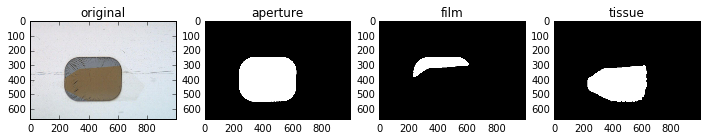

In [88]:
create_all_images('239849_7R', '1', '002344', ai)
create_aperture_mask(ai)
create_tissue_mask(ai)
create_film_mask(ai)

fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(ncols=4, figsize=(12, 8))
ax_1.imshow(ai['imrgb'])
ax_1.set_title('original')
ax_2.imshow(ai['im_mask_aperture'])
ax_2.set_title('aperture')
ax_3.imshow(ai['im_mask_film'])
ax_3.set_title('film')
ax_4.imshow(ai['im_mask_tissue'])
ax_4.set_title('tissue')
plt.show()

In [50]:
# crop the image to the interesting part, convert to HSV
xoff = 100
yoff = 300
imc = im[yoff:, xoff:1000, :]
#print (imc.dtype, imc.max())
imhsv = color.rgb2hsv(imc)
imgray = color.rgb2gray(imc)
print (imgray.dtype, imgray.max())

(dtype('float64'), 0.91859333333333337)


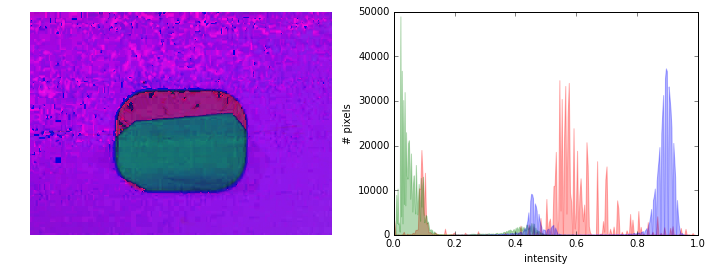

In [51]:
skdemo.imshow_with_histogram(imhsv[:,:,:]);

0.350569661458


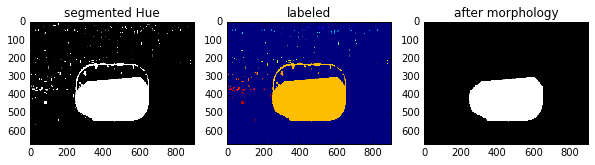

In [52]:
#convert to HSV space
imv = imhsv[:,:,0]
threshold = filters.threshold_otsu(imv )
print threshold
imb = imv < threshold
#skdemo.imshow_with_histogram(imb);
imb = skimage.img_as_int(imb)

# label it
imlabel = morphology.label(imb)

# remove small blobs
imnosmall = morphology.remove_small_objects(imlabel, min_size=4000, connectivity=1, in_place=False)

# fill small holes
imnosmall = morphology.remove_small_holes(imnosmall, min_size=200, connectivity=2, in_place=False)

# trim tendrils
se = morphology.disk(5)
imnosmall = morphology.opening(imnosmall, se)

# remove small blobs
imnosmall = morphology.remove_small_objects(imnosmall, min_size=4000, connectivity=1, in_place=False)

fig, (ax_1, ax_2, ax_3) = plt.subplots(ncols=3, figsize=(10, 5))
ax_1.imshow(imb, cmap='gray')
ax_1.set_title('segmented Hue')
ax_2.imshow(imlabel, cmap='jet')
ax_2.set_title('labeled')
ax_3.imshow(imnosmall, cmap='gray')
ax_3.set_title('after morphology')
plt.show()

In [53]:
print (imnosmall.dtype, imnosmall.max(), imnosmall.shape)
image = skimage.img_as_ubyte(imgray)
print (image.dtype, image.max(), image.shape)
image[:,:] = 0
image[imnosmall != 0] = 255
#skdemo.imshow_with_histogram(image);

(dtype('bool'), True, (667L, 900L))
(dtype('uint8'), 234, (667L, 900L))


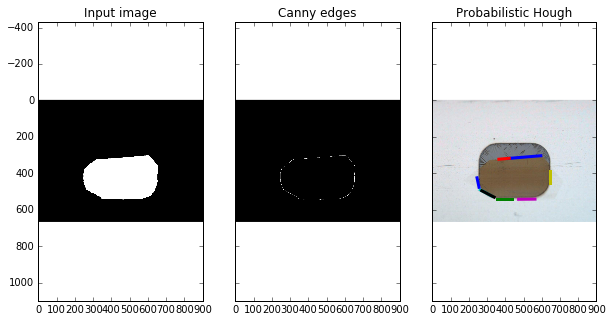

In [54]:
# Line finding using the Probabilistic Hough Transform.
edges = feature.canny(image, sigma=4.0)
lines = transform.probabilistic_hough_line(edges)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5), sharex=True,
                                    sharey=True)
ax0.imshow(image, 'gray')
ax0.set_title('Input image')

ax1.imshow(edges, 'gray')
ax1.set_title('Canny edges')

ax2.imshow(imc)
for line in lines:
    p0, p1 = line
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]), linewidth=3.0)

row2, col2 = image.shape
ax2.axis((0, col2, row2, 0))

ax2.set_title('Probabilistic Hough')


('Number of coordinates:', 1085, 34, 13)


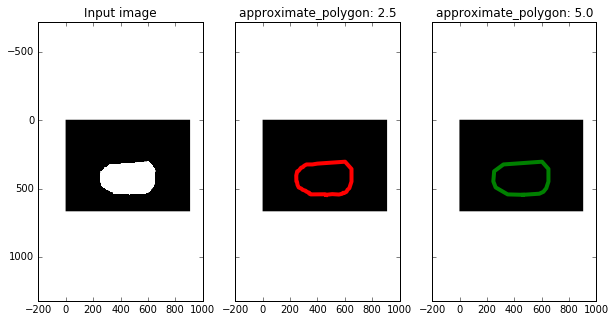

In [55]:
# Much better solution: find contours and then subsample the polygon
contours = measure.find_contours(image, 0.5)
tolerance1 = 2.5
tolerance2 = 5.0

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5), sharex=True,
                                    sharey=True)
ax0.imshow(image, 'gray')
ax0.set_title('Input image')

ax1.imshow(edges, 'gray')
ax1.set_title('approximate_polygon: ' + str(tolerance1))

ax2.imshow(edges, 'gray')
ax2.set_title('approximate_polygon: ' + str(tolerance2))

for contour in measure.find_contours(image, 0):
    coords = measure.approximate_polygon(contour, tolerance=tolerance1)
    ax1.plot(coords[:, 1], coords[:, 0], '-r', linewidth=4)
    coords2 = measure.approximate_polygon(contour, tolerance2)
    ax2.plot(coords2[:, 1], coords2[:, 0], '-g', linewidth=4)
    print("Number of coordinates:", len(contour), len(coords), len(coords2))
